# Lab 6: Train MNIST dataset with CNN

The purpose of this assignment is to use the MNIST dataset and train a model from that dataset. Using different data preprocessing methods and neural network sizes, the accuracy of those models could vary greatly. We intend to find a model that is as accurate as possible after testing different methods.

## Imports

Libraries and modules that are needed to train the MNIST dataset and visualize the results
<hr>

In [41]:
# Core libraries
import json
import numpy as np
import pandas as pd
# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
# Torch libraries
import torch
from torchsummary import summary
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
# TorchVision libraries
from torchvision import transforms, models, datasets
from torchvision.utils import make_grid
from PIL import Image
# SCI learn libraries
from sklearn.metrics import confusion_matrix
# Memory profiler
import memory_profiler  # conda install -c anaconda memory_profiler  |  conda install -c conda-forge memory_profiler

## Neural Network Classification

We will define the model to use in Multi Layer Perceptron (MLP)
<hr>

In [12]:
# Define the neural network model
class MNIST_CNN(nn.Module):
    def __init__(self, input_size, hidden_size, kernel_size, output_size):
        super(MNIST_CNN, self).__init__()

        self.main = nn.Sequential(
            # 1st convolution
            nn.Conv2d(input_size, hidden_size, kernel_size, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0), # Kernel size: 2, stride: 2, padding: 0
            # 2nd convolution
            nn.Conv2d(hidden_size, hidden_size*2,kernel_size, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0), # Kernel size: 2, stride: 2, padding: 0
            # Flatten Layer: Converts the multi-dimensional feature maps into a 1D vector
            nn.Flatten(),         
            # Flattened Features: 64 * 7 * 7
            # First Fully Connected (Linear) Layer: Connects the flattened input to 128 neurons
            # Input size: 3136 (flattened size after convolutions and pooling)
            # Output size: 128 (hidden layer)
            nn.Linear(3136, 128),
            nn.ReLU(),
            # Second Fully Connected (Linear) Layer: Maps the 128 neurons to a single output neuron
            # Input size: 128 (hidden layer)
            # Output size: 10 (clustering for numbers 0 - 9)
            nn.Linear(128, output_size) 
        )

    def forward(self, x):
        out = self.main(x)
        return out

### PyTorch Tensor

Convert the input data, X (features) and y (labels), into PyTorch tensors to be used with PyTorch models.

train_dataset and test_dataset are created as tensors with the MNIST datasets, which is required for our training data requirements.

Next, we need to determine how to preprocess the dataset. Since many CNN datasets do well with Mean and Standard Deviation (STD)

We will evaluate that first, but we will compare Min-Max Scaling as well.

In [13]:
# Basic Transform for tensor creation
transform = transforms.Compose([transforms.ToTensor()])

# Get the train and test datasets from the torch MNIST
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

### Dataset Details

Here are the details about the MNIST dataset, including 

In [14]:
# Output the MNIST dataset details
print(f"Dataset: {train_dataset}")
print(f"Classes: {train_dataset.classes}")
print(f"Class count: {len(train_dataset.classes)}")
print(f"Sample count:",len(train_dataset))

# Get the next image from the train dataset
img, target = next(iter(train_dataset))
print(f"Image shape:",img.shape)

Dataset: Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
Class count: 10
Sample count: 60000
Image shape: torch.Size([1, 28, 28])


### Assess Dataset Distribution

Let's do a breakdown of the Raw pixel values, normalization methods, and comparisons between the two
<hr>

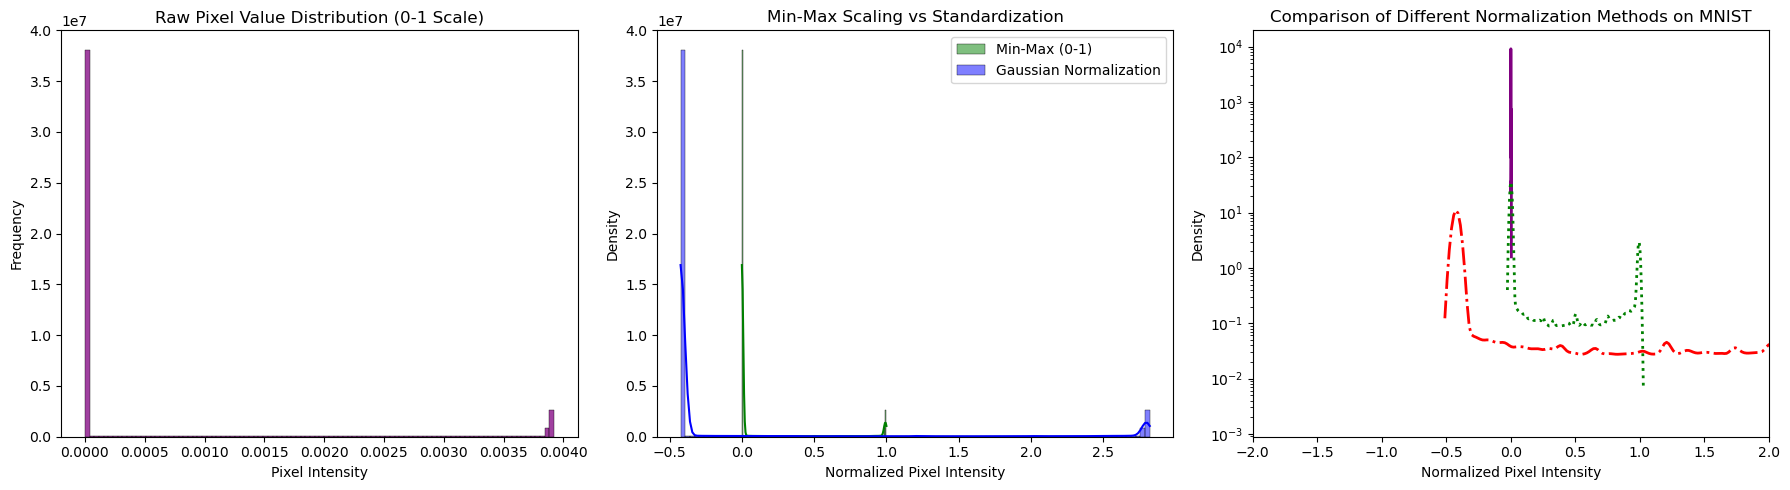

In [15]:
# Convert dataset to a NumPy array of pixel values (flatten all tensors)
pixel_values = torch.cat([img.view(-1) for img, _ in train_dataset]).numpy()

# 1. Raw Pixel Values (scaled between [0,1])
raw_pixel_values = pixel_values / 255.0

# 2. Min-Max Normalization (0 to 1)
min_val = np.min(pixel_values)
max_val = np.max(pixel_values)
normalized_minmax = (pixel_values - min_val) / (max_val - min_val)

# 3. Standardization (Z-score scaling)
mean = np.mean(pixel_values)
std = np.std(pixel_values)
standardized_pixels = (pixel_values - mean) / std

# Create a figure
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Histogram of Raw Pixel Values
sns.histplot(raw_pixel_values, bins=100, kde=False, color="purple", ax=axes[0])
axes[0].set_title("Raw Pixel Value Distribution (0-1 Scale)")
axes[0].set_xlabel("Pixel Intensity")
axes[0].set_ylabel("Frequency")

# 2. Overlaid Histogram: Min-Max vs Standardization
sns.histplot(normalized_minmax, bins=100, kde=True, color="green", label="Min-Max (0-1)", alpha=0.5, ax=axes[1])
sns.histplot(standardized_pixels, bins=100, kde=True, color="blue", label="Gaussian Normalization", alpha=0.5, ax=axes[1])
axes[1].set_title("Min-Max Scaling vs Standardization")
axes[1].set_xlabel("Normalized Pixel Intensity")
axes[1].set_ylabel("Density")
axes[1].legend()

# 3. Comparison of Min-Max Scaling to Normalization of MNIST
sns.kdeplot(raw_pixel_values, color="purple", linestyle="solid", linewidth=2, label="Raw Pixels (0-1)", ax=axes[2])
sns.kdeplot(normalized_minmax, color="green", linestyle="dotted", linewidth=2, label="Min-Max (0-1)", ax=axes[2])
sns.kdeplot(standardized_pixels, color="red", linestyle="dashdot", linewidth=2, label="Gaussian Normalization", ax=axes[2])
axes[2].set_title("Comparison of Different Normalization Methods on MNIST")
axes[2].set_xlabel("Normalized Pixel Intensity")
axes[2].set_ylabel("Density")
axes[2].set_xlim(-2, 2)   # Zoom in on relevant range (removing extreme outliers)
axes[2].set_yscale("log") # Use log scale to highlight density differences

# Show plots
plt.tight_layout()
plt.show()

## Determination for Pre-processing

Since the distribution of the data set has many outliers, it is better to use normalization first to ensure we do not lose features that are outliers. To do this, we will calculate the <em>mean</em> and the <em>standard deviation (std)</em> of the MNIST dataset.

Without any data pre-processing, the length of time it could take for the model to converge could be slower, and in some cases the calculaion costs can be higher since the delta between the numbers will be larger; the smaller we can make the delta and still preserve the relative distances, the easier the calculative costs will be.

In [16]:
# Initialize variables to accumulate sums
sum_pixels = 0.0
sum_squared_pixels = 0.0
num_pixels = 0

# Iterate through the dataset to compute sums
for images, _ in train_dataset:
    # Flatten the image to a 1D tensor
    images = images.view(-1)  # Shape: (784,)
    
    # Update sums
    sum_pixels += images.sum().item()
    sum_squared_pixels += (images ** 2).sum().item()
    num_pixels += images.numel()

# Compute mean and standard deviation
mean = sum_pixels / num_pixels
std = (sum_squared_pixels / num_pixels - mean ** 2) ** 0.5

print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")

Mean: 0.13066047797803165
Standard Deviation: 0.3081078048756658


### Data Normalization (Preprocessing)

Now, we can normalize the data using the values that we calculated

In [54]:
# Configure the mean and standard deviation (for pre-processing)
MNIST_MEAN = mean
MNIST_STD = std

# Step 1: Load and preprocess the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((MNIST_MEAN,), (MNIST_STD,))  # Normalize with mean and std of MNIST
])

# Get the train and test datasets from the torch MNIST
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

## Data Loader Creation (training preparation)

Create the data loaders that are batched and shuffled according to the type of dataset it is:
1. train_dataset is shuffled as this is trained
2. test_dataset is not shuffled, as this is used to validate trained predictions.

<hr>

In [55]:
# Set batch size
BATCH_SIZE = 64

# Step 3: Create DataLoader for batching and shuffling
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

#### Analyzer data batches
Let's analyze the dimensions of the images and batch memory size

In [56]:
mem = memory_profiler.memory_usage()[0]
imgs, targets = next(iter(train_loader))
print(f"       # of batches: {len(train_loader)}")
print(f"    Image data type: {type(imgs)}")
print(f"   Image batch size: {imgs.shape}")  # dimensions are (batch size, image channels, image height, image width)
print(f"  Target batch size: {targets.shape}")
print(f"       Batch memory: {memory_profiler.memory_usage()[0] - mem:.2f} mb")  # memory usage after loading batch

       # of batches: 938
    Image data type: <class 'torch.Tensor'>
   Image batch size: torch.Size([64, 1, 28, 28])
  Target batch size: torch.Size([64])
       Batch memory: 0.53 mb


### Example Sample
Example of an image from the dataset
<hr>

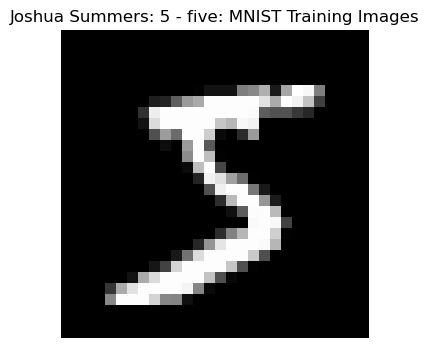

In [57]:
# Get the next image from the train dataset
img, target = next(iter(train_dataset))

# Plot the image
plt.figure(figsize=(4, 4)); plt.axis("off"); plt.title(f"Joshua Summers: {train_dataset.classes[target]}: MNIST Training Images")
plt.imshow(np.transpose(make_grid(img, padding=1, normalize=True),(1,2,0)));

### Plot samples
<hr>

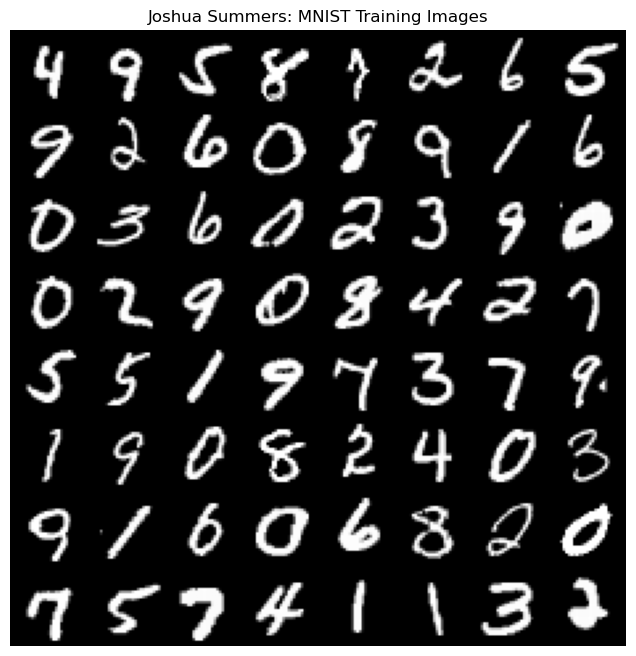

In [58]:
# Plot samples
sample_batch = next(iter(train_loader))
plt.figure(figsize=(10, 8)); plt.axis("off"); plt.title("Joshua Summers: MNIST Training Images")
plt.imshow(np.transpose(make_grid(sample_batch[0], padding=1, normalize=True),(1,2,0)));

## Model Trainer Function

This model uses MPS integration and, as such, incorporates sending tensors to the MPS pipeline.
<hr>

In [32]:
def trainer(model, criterion, optimizer, trainloader, testloader, epochs=10, verbose=True):
    """
    Train and validate a PyTorch model.
    
    Args:
        model: PyTorch model to train.
        criterion: Loss function.
        optimizer: Optimizer for updating weights.
        trainloader: DataLoader for training data.
        testloader: DataLoader for validation data.
        epochs: Number of epochs for training.
        verbose: If True, print progress for each epoch.
    
    Returns:
        A dictionary containing training loss, validation loss, and validation accuracy.
    """
    
    train_loss, valid_loss, valid_accuracy = [], [], []
    for epoch in range(epochs):  # for each epoch
        train_batch_loss = 0
        #valid_batch_loss = 0
        #valid_batch_acc = 0
        
        # Training
        model.train()
        for X, y in trainloader:
            # needed for MPS device integration
            X = X.to(device) 
            y = y.to(device)
            
            optimizer.zero_grad() # Reset gradients
            y_hat = model(X) # Forward pass: Compute the model's prediction
            loss = criterion(y_hat, y.type(torch.float32)) # Compute loss between predicted values and actual labels
            loss.backward() # Backpropagation: compute gradients
            optimizer.step() # Update model parameters using optimizer
            train_batch_loss += loss.item() # Accumulate batch loss
        # Track this iteration loss
        train_loss.append(train_batch_loss / len(trainloader)) # Compute average training loss for this epoch
        
        # Validation
        model.eval() # Set the model to evaluation mode (disables dropout/batchnorm layers if any)
        correct = 0
        total = 0
        with torch.no_grad():  # this stops pytorch doing computational graph stuff under-the-hood and saves memory and time
            for X, y in testloader:
                # needed for MPS device integration
                X = X.to(device)
                y = y.to(device)
                
                y_hat = model(X) # Forward pass: compute predictions for validation set

                # Predictions
                _, predicted = torch.max(y_hat.data, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()
        # Accuracy record append
        valid_accuracy.append(100 * correct / total)
        
        # Print progress
        if verbose:
            print(f"Epoch {epoch + 1}:",
                  f"Train Loss: {train_loss[-1]:.3f}.",
                  f"Test Accuracy: {100 * correct / total:.2f}%")
    
    results = {"train_loss": train_loss,
               "valid_accuracy": valid_accuracy}
    return results  

### Initialize the model

We will define the model parameters and initialize the criterion and optimization functions.
Then, we will train the model and store the results.

This model will only be trained for 25 epochs as the accuracy hits 99% by then,
and any additional epochs do not increase the accuracy.

In [59]:
# Step 4: Initialize the model, loss function, and optimizer
# Input size
INPUT_SIZE = 1
HIDDEN_NETWORK = 32
KERNEL_SIZE = 3
OUTPUT_SIZE = 10
EPOCHS=25

# GPU available?
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Training Using: {device}")

# Define the model and the criterion/optimizer
model = MNIST_CNN(INPUT_SIZE, HIDDEN_NETWORK, KERNEL_SIZE, OUTPUT_SIZE).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Timestamp tracking
from datetime import datetime
# Get time and format it
current_time = datetime.now() # Get the current timestamp
formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S") # Format the timestamp
# Print the formatted timestamp
print("Starting Timestamp:", formatted_time)

#Train the model using the trainer function
results = trainer(model, criterion, optimizer, train_loader, test_loader, epochs=EPOCHS)

# End Timestamp
current_time = datetime.now() # Get the current timestamp
# Print the formatted timestamp
#print("Ending Timestamp:", formatted_time)

Training Using: mps
Starting Timestamp: 2025-03-11 23:57:54
Epoch 1: Train Loss: 0.130. Test Accuracy: 98.39%
Epoch 2: Train Loss: 0.042. Test Accuracy: 98.79%
Epoch 3: Train Loss: 0.027. Test Accuracy: 98.94%
Epoch 4: Train Loss: 0.020. Test Accuracy: 98.92%
Epoch 5: Train Loss: 0.016. Test Accuracy: 99.04%
Epoch 6: Train Loss: 0.012. Test Accuracy: 98.99%
Epoch 7: Train Loss: 0.011. Test Accuracy: 99.16%
Epoch 8: Train Loss: 0.008. Test Accuracy: 99.07%
Epoch 9: Train Loss: 0.007. Test Accuracy: 99.18%
Epoch 10: Train Loss: 0.008. Test Accuracy: 99.09%
Epoch 11: Train Loss: 0.005. Test Accuracy: 99.10%
Epoch 12: Train Loss: 0.006. Test Accuracy: 99.12%
Epoch 13: Train Loss: 0.005. Test Accuracy: 99.16%
Epoch 14: Train Loss: 0.006. Test Accuracy: 99.09%
Epoch 15: Train Loss: 0.004. Test Accuracy: 99.12%
Epoch 16: Train Loss: 0.005. Test Accuracy: 99.22%
Epoch 17: Train Loss: 0.003. Test Accuracy: 99.10%
Epoch 18: Train Loss: 0.005. Test Accuracy: 99.06%
Epoch 19: Train Loss: 0.002. Te

### Save your Model
We will save our model reflecting 99% accuracy
<hr>

In [60]:
# Saved model after first training
PATH = "models/MNIST_acc99.pt"
torch.save(model, PATH)

### Output model summary
<hr>

In [61]:
# Summary of the model details
model = model.to("cpu") # Needed for torchsummary compatibility as mps is not supported
summary(model, (1, 28, 28)) # Since we are sending it a grayscale 28 x 28 pixel image

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
           Flatten-7                 [-1, 3136]               0
            Linear-8                  [-1, 128]         401,536
              ReLU-9                  [-1, 128]               0
           Linear-10                   [-1, 10]           1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 1.61
Estimated T

## Visualizations
<hr>

This is the Loss Accuracy graph for the model

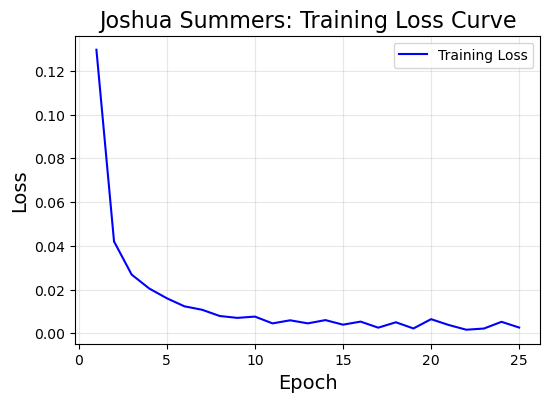

In [62]:
# Your code
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(results["train_loss"]) + 1), results["train_loss"], label="Training Loss", color="blue")
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.title("Joshua Summers: Training Loss Curve", fontsize=16)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

This is the Validation Accuracy graph for the model

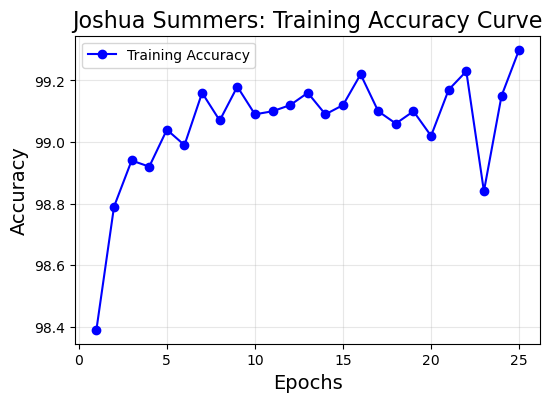

In [63]:
# Setup the plot
plt.figure(figsize=(6,4))
plt.plot(range(1, len(results["valid_accuracy"]) + 1), results["valid_accuracy"], marker='o', linestyle='-', color='b', label="Training Accuracy")
# Label and title graph
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Joshua Summers: Training Accuracy Curve", fontsize=16)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

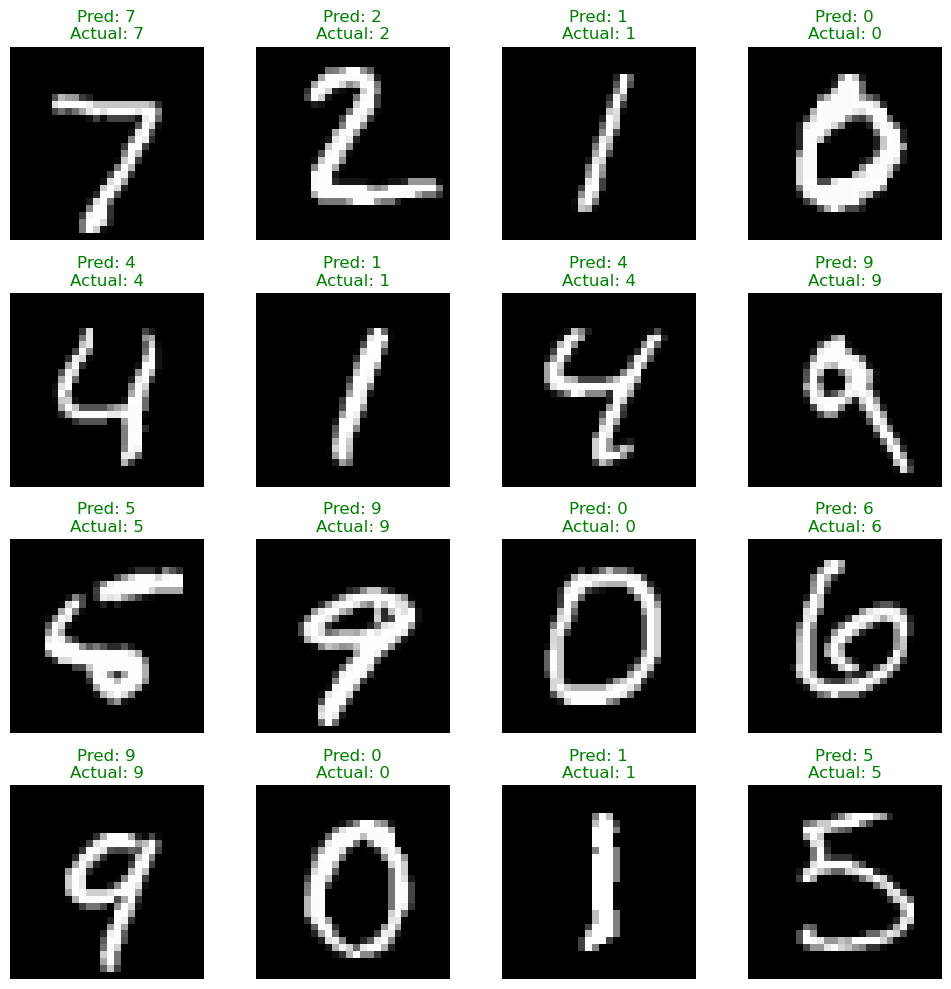

In [64]:
# Get a batch of test images
images, labels = next(iter(test_loader))

# Make predictions
with torch.no_grad():
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)

# Convert images to NumPy for visualization
images = images.numpy()

# Plot images with predicted and actual labels
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.flatten()

for i in range(16):
    img = np.squeeze(images[i])  # Remove channel dimension
    axes[i].imshow(img, cmap="gray")
    color = "green" if predictions[i] == labels[i] else "red"  # Highlight incorrect predictions
    axes[i].set_title(f"Pred: {predictions[i].item()}\nActual: {labels[i].item()}", color=color)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

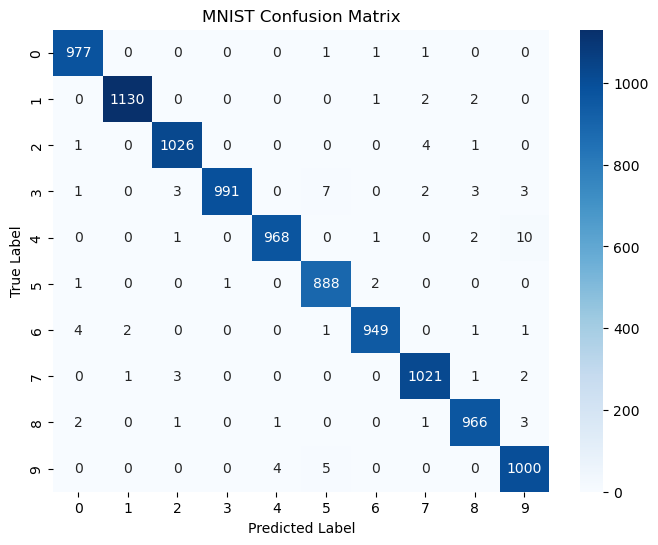

In [49]:
# Get predictions and actual labels
all_preds = []
all_labels = []

# Get the predictions
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        all_preds.extend(predictions.numpy())
        all_labels.extend(labels.numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("MNIST Confusion Matrix")
plt.show()

## Prediction Tests

We will run two predictions from the model to determine the accuracy
<hr>

### Prediction for five

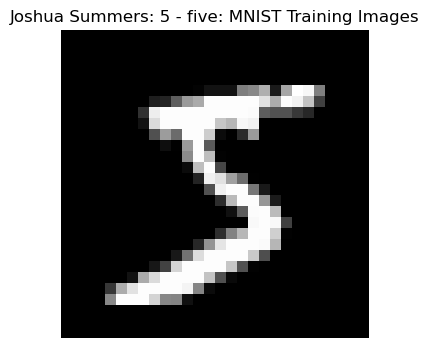

In [50]:
# Predict a class from a picture
img, target = next(iter(train_dataset))
label = train_dataset.classes[target]

# Show image
plt.figure(figsize=(4, 4)); plt.axis("off"); plt.title(f"Joshua Summers: {train_dataset.classes[target]}: MNIST Training Images")
plt.imshow(np.transpose(make_grid(img, padding=1, normalize=True),(1,2,0)));

In [51]:
# Make a tensor from the image
image_tensor = img.to(device).unsqueeze(0) # needed for MPS device integration

# Make sure the model is sent to the proper device
model = model.to(device)

# Get the raw prediction
prediction_raw = model(image_tensor)

# Interpret the output
predicted_class = torch.argmax(prediction_raw, dim=1).item()
print(f"Predicted class: {predicted_class}, True label: {target}")

Predicted class: 5, True label: 5


### Prediction for zero

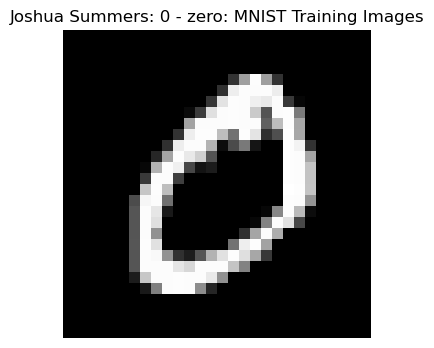

In [52]:
# Predict a class from a picture
img, target = train_dataset[1]
label = train_dataset.classes[target]

# Show image
plt.figure(figsize=(4, 4)); plt.axis("off"); plt.title(f"Joshua Summers: {train_dataset.classes[target]}: MNIST Training Images")
plt.imshow(np.transpose(make_grid(img, padding=1, normalize=True),(1,2,0)));

In [53]:
# Make a tensor from the image
image_tensor = img.to(device).unsqueeze(0) # needed for MPS device integration

# Make sure the model is sent to the proper device
model = model.to(device)

# Get the raw prediction
prediction_raw = model(image_tensor)

# Interpret the output
predicted_class = torch.argmax(prediction_raw, dim=1).item()
print(f"Predicted class: {predicted_class}, True label: {target}")

Predicted class: 0, True label: 0


# Conclusion

We have now trained the model and shown that two predictions matched properly. This model has 99% accuracy and is a good candidate for number image predictions.